In [0]:

## Replicating from following web
##https://github.com/borisbanushev/stockpredictionai


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from google.colab import drive
import pandas as pd


drive.mount('/content/gdrive')
stock_file = '/content/gdrive/My Drive/data/GSLC.csv'









In [0]:
# TBD Not working
from utils import *
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

In [0]:

import time
import numpy as np



from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from pandas import DataFrame
from pandas import datetime


#import pandas as pd
df = pd.read_csv(stock_file)

dataset_ex_df = df[['Date', 'Close']]

dataset_ex_df.columns = ['Date', 'price']

pd.DataFrame(dataset_ex_df)

print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 251 number of days in the dataset.


There are 251 number of days in the dataset.


TypeError: ignored

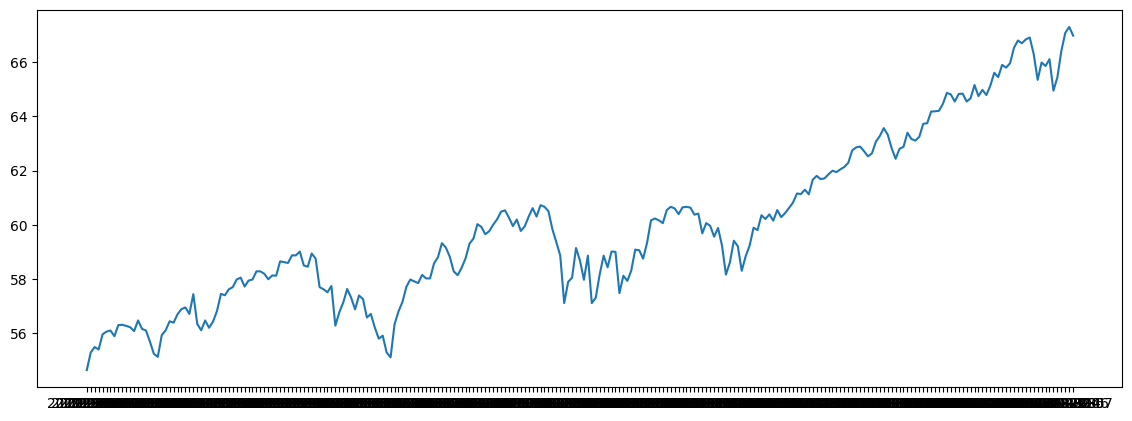

In [6]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['price'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()


In [7]:

num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))




Number of training days: 175. Number of test days: 76.



# Technical indicators


In [19]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['price'].rolling(window=7,min_periods=1).mean()
    dataset['ma21'] = dataset['price'].rolling(window=21,min_periods=1).mean()
    
    # Create MACD
    dataset['26ema'] = pd.DataFrame.ewm(dataset['price'], span=26).mean()  #pd.ewma(dataset['price'], span=26)
    dataset['12ema'] = pd.DataFrame.ewm(dataset['price'], span=12).mean()  #pd.ewma(dataset['price'], span=12)
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = pd.Series(dataset['price']).rolling(window=20,min_periods=1).std()
    # pd.rolling_std(dataset['price'],20)   #pd.stats.moments.rolling_std(dataset['price'],20)
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])

    return dataset

dataset_price = dataset_ex_df[['price']]
dataset_price.columns = ['price']

#pd.DataFrame(dataset_price)

dataset_TI_df = get_technical_indicators(dataset_price)

pd.DataFrame(dataset_TI_df)


,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,54.650002,54.650002,54.650002,54.650002,54.650002,0.000000,NaN,NaN,NaN,54.650002,53.650002,3.982482
1,55.299999,54.975001,54.975001,54.987500,55.002084,0.014583,0.459617,55.894235,54.055766,55.137500,54.299999,3.994524
2,55.500000,55.150000,55.150000,55.171637,55.196421,0.024784,0.444408,56.038817,54.261183,55.388461,54.500000,3.998201
3,55.410000,55.215000,55.215000,55.238273,55.263839,0.025567,0.385442,55.985885,54.444115,55.403000,54.410000,3.996548
4,55.970001,55.366000,55.366000,55.407963,55.455701,0.047737,0.474794,56.315589,54.416412,55.782563,54.970001,4.006788
...,...,...,...,...,...,...,...,...,...,...,...,...
246,65.440002,65.714286,65.816667,65.484075,65.795050,0.310975,0.662317,67.141300,64.492033,65.396832,64.440002,4.165735
247,66.410004,65.730000,65.895715,65.552662,65.889658,0.336996,0.637919,67.171552,64.619877,66.072280,65.410004,4.180675
248,67.080002,65.977144,65.995715,65.665798,66.072788,0.406990,0.625759,67.247232,64.744197,66.744095,66.080002,4.190866
249,67.300003,66.164287,66.115238,65.786851,66.261590,0.474740,0.644594,67.404426,64.826051,67.114700,66.300003,4.194190


# Plot Technical Indicator

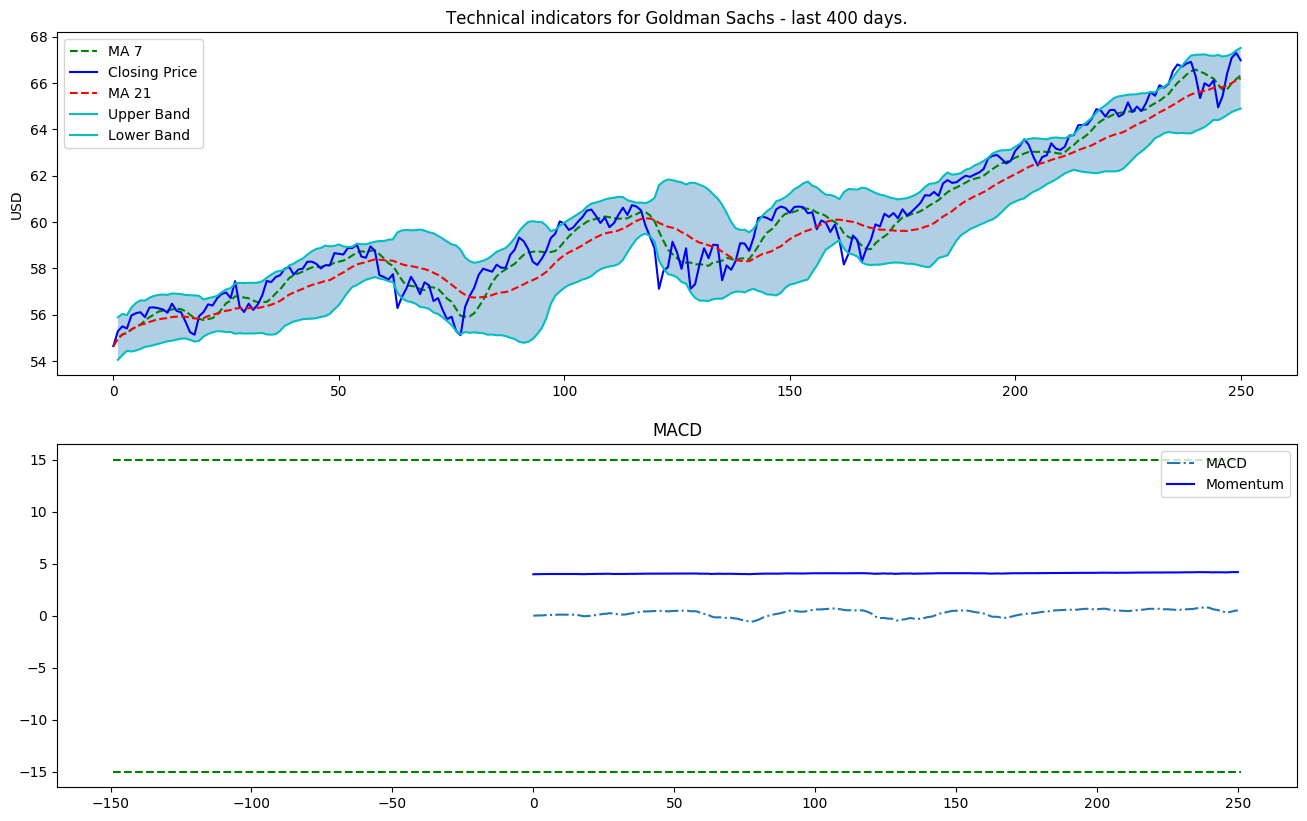

In [20]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

plot_technical_indicators(dataset_TI_df, 400)

# Fourier transforms trend analysis

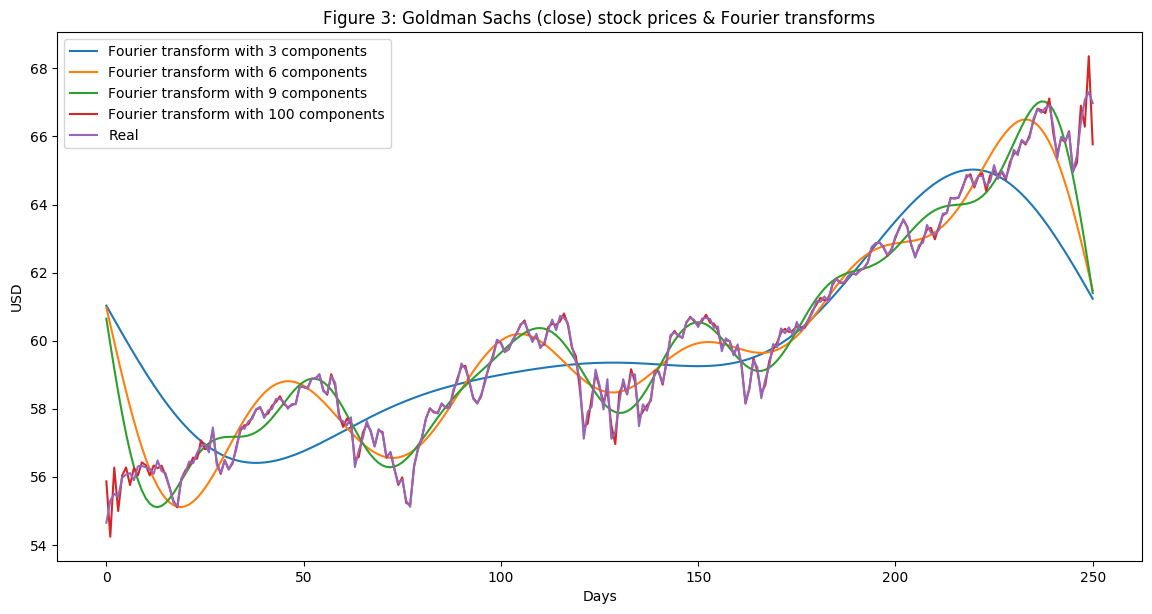

In [22]:


data_FT = dataset_ex_df[['Date', 'price']]


close_fft = np.fft.fft(np.asarray(data_FT['price'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['price'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()



# Wavelet - Denoise 

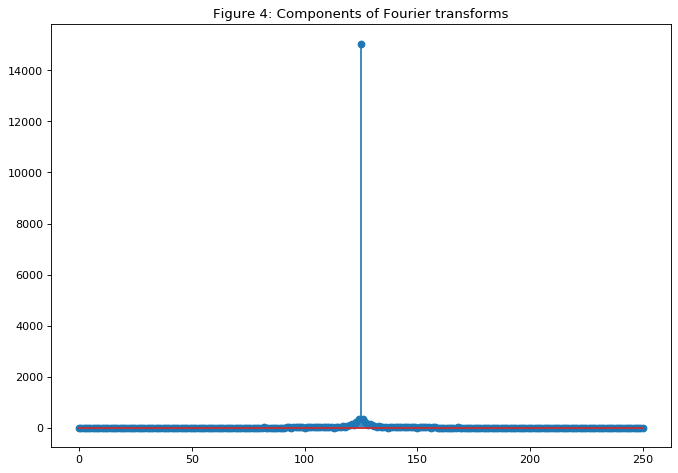

In [23]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

# ARIMA For stock prediction

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  250
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -151.060
Method:                       css-mle   S.D. of innovations              0.443
Date:                Wed, 12 Feb 2020   AIC                            316.120
Time:                        06:34:52   BIC                            340.770
Sample:                             1   HQIC                           326.041
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0484      0.023      2.149      0.033       0.004       0.093
ar.L1.D.price    -0.0633      0.063     -1.000      0.318      -0.187       0.061
ar.L2.D.price    -0.0887      0.063     

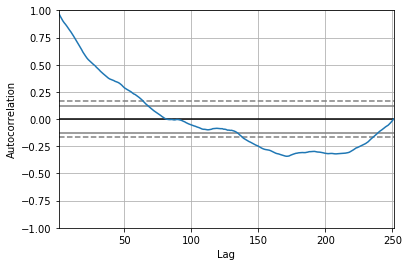

<Figure size 800x560 with 0 Axes>

In [26]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['price']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

